# Simulated stellar dynamic spectra analysis

__Andrew Zic__<br>
__5th Chinese SKA Summer School__<br>
__2019-08-15__<br>

In this exercise, we will process and analyse simulated dynamic spectra from an active M-dwarf, UV Ceti, that resembles ASKAP observations of UV Ceti presented in my recent paper. Bursty emission from M-dwarfs at radio frequencies is often very highly polarised, occurs over (relatively) short timescales of seconds to minutes, and can show large amounts of spectral structure as well. Dynamic spectra (showing amplitude as a function of time and frequency) is therefore a fantastic way to obtain detailed information about these bursts.

The dynamic spectra in this exercise are initially given for each instrumental polarisation ($XX$, $YY$, $XY$, and $YX$), and for each baseline of a 16-antenna array (giving $(16\times15)/2 = 120$ baselines).

Prior processing of the data presented here would have included calibration of the visibilities (including bandpass calibration, flux density scaling, complex gain & leakage calibration, and $XY$-phase calibration). The visibilities were inverted and deconvolved, using the deconvolution process to store a model of the field sources around the target star. The sky model constructed during deconvolution is then subtracted from the calibrated visibilities, leaving only the amplitude of the target star remaining in the residual visibilities. The target star was at the phase centre of the observations - if it weren't, then the visibilities would need to be phase-shifted to the location of the target star after calibration and imaging. 

In this tutorial, we will:
- Inspect the data
- Process the data to form dynamic spectra for the four Stokes parameters ($I$, $Q$, $U$, $V$)
- Analyse the features of the dynamic spectra

In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import correlate2d, convolve

%matplotlib inline

### Loading the data

The data for each instrumental polarisation and each baseline are stored in three-dimensional numpy arrays. The dimensions are time, observing frequency, and baseline number. Each cell in the arrays stores the amplitude of the calibrated and subtracted visibilities for each baseline, for each integration, and for each spectral channel.<br>
We will use the `np.load` function to load in the numpy arrays.

In [27]:
#time data, in hours
time = np.load('time.npy')

#frequency channel data, in MHz
freq = np.load('freq.npy')

#XX data
XX_baseline = np.load('XX_baselines.npy')

#YY data
YY_baseline = np.load('YY_baselines.npy')

#XY data
XY_baseline = np.load('XY_baselines.npy')

#YX data
YX_baseline = np.load('YX_baselines.npy')

### Inspecting the data

We can examine how many time samples and frequency channels we have for our dynamic spectra by finding the length of the time and frequency arrays:

In [24]:
n_time_samps = len(time) #number of time samples
n_chans = len(freq) #number of frequency channels

print('Number of time samples: {}'.format(n_time_samps))
print('Number of channels: {}'.format(n_chans))

Number of time samples: 1899
Number of channels: 72


#### Exercise:
Determine the duration, time resolution, bandwidth, and spectral resolution of this data.

__Hint__ - `python` indexing begins from 0. This means to get the first element of the 1-D `time` array, use `time[0]`. The second element is `time[1]`, and so on. To get the last element, you can use `time[len(time) - 1]`, or more conveniently, `time[-1]`.

In [ ]:
#time resolution in hours:

time_res = #complete this line

#duration in hours:

duration = #complete this line

#frequency resolution in MHz:

freq_res = #complete this line

#frequency bandwidth in MHz:

bandwidth = #complete this line

print("""Time resolution: {} hours
Duration: {} hours
Frequency resolution: {} MHz
Bandwidth: {} MHz""".format(time_res, duration, freq_res, bandwidth))

We inspect the data structure and properties below:

In [41]:
print('XX dynamic spectrum dimensions: {}'.format(XX_baseline.shape))

XX dynamic spectrum dimensions: (1899, 72, 120)


So there are 1899 time samples, 72 frequency channels, for 120 baselines. We can see that time forms the first axis of the dynamic spectrum array (index 0), frequency forms the second axis (index 1), and the baselines form the third axis of the array (index 2).

In the next line, we use the `dtype` attribute to see what type of data we are working with:

In [18]:
XX_baseline.dtype

dtype('complex128')

So we are working with complex-valued data. This makes sense - an interferometer measures the correlations of complex voltages.

As an example, let's plot the $XX$ data from one baseline.

When plotting the dynamic spectra, we transpose it using `np.transpose`, so that we have time on the $x$-axis and frequency on the $y$-axis.

Remember that the visibilities are complex-valued, so we can try plotting the real and imaginary parts separately. For this, we will use `np.real` and `np.imag`.

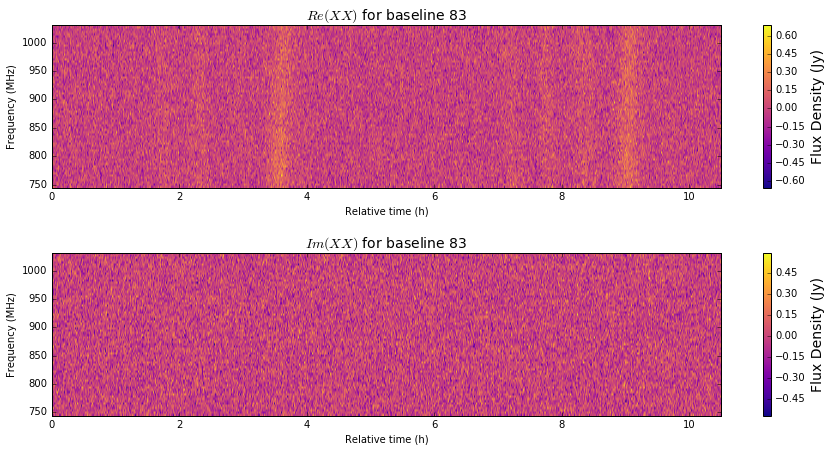

In [72]:
#first, initialise a figure with two subplots:
fig, (ax1, ax2) = plt.subplots(2, #two rows of axes
                               1, #one column of axes
                              figsize = (15, 7) # a nice big figure
                              )

#choose any baseline number:
baseline = 83

#get the XX dynamic spectrum for this baseline:
XX_test = XX_baseline[:, :, baseline] # The colon ":" selects all indices for that axis

#now we plot the real and imaginary parts using pyplot's imshow function
re = ax1.imshow(np.transpose(np.real(XX_test)),
          aspect = 'auto', #make the aspect ratio sensible
          origin = 'lower', #put the origin in the lower left corner
          extent = [time[0], time[-1], freq[0], freq[-1]], #set the axis values
          cmap = 'plasma' #Feel free to experiment with different colormaps e.g. viridis, magma, Blues
          )
#create a color-bar and set its label
fig.colorbar(re, ax = ax1).set_label('Flux Density (Jy)', fontsize = 14)


#set the axis labels
ax1.set_xlabel('Relative time (h)')
ax1.set_ylabel('Frequency (MHz)')
ax1.set_title(r'$Re(XX)$ for baseline {}'.format(baseline), fontsize = 14)

im = ax2.imshow(np.transpose(np.imag(XX_test)),
          aspect = 'auto', #make the aspect ratio sensible
          origin = 'lower', #put the origin in the lower left corner
          extent = [time[0], time[-1], freq[0], freq[-1]], #set the axis values
          cmap = 'plasma' #use an attractive colormap
          )
#create a color-bar and set its label
fig.colorbar(im, ax = ax2).set_label('Flux Density (Jy)', fontsize = 14)

#set the axis labels
ax2.set_xlabel('Relative time (h)')
ax2.set_ylabel('Frequency (MHz)')
ax2.set_title(r'$Im(XX)$ for baseline {}'.format(baseline), fontsize = 14)

fig.subplots_adjust(hspace = 0.4) #adjust subplots so that axis labels and titles don't overlap

So we can see that there appears to be some signal in the real part of $XX$ for this baseline, and the imaginary part appears to contain only noise.

#### Exercise

Copy and paste the code from above into the cell below. Change your code so that it plots the real and imaginary components of the $XY$ instrumental polarisation for one baseline. What do you notice about the real and imaginary components of the $XY$ visibilities compared with the $XX$ visibilities?

You should have noticed that the real part of $XY$ appears to contain only noise, and the imaginary part of $XY$ appears to contain some signal. Why might this be? What does this tell us about the signal we are detecting?

## Processing the data

So far, we have been working with the 120 individual baselines from our 16-element array. You might have noticed some strong indications of some emission in the dynamic spectra you plotted above, but ideally we want to make use of the full array in detecting structure in our dynamic spectra. To do this, we will average the dynamic spectra over all baselines, for each instrumental polarisation.

Fortunately this is straightforward with the use of `np.mean`, which allows you to take the average of any $N$-dimensional array over a specified axis. In our case, the baselines form the third axis of the array, so we will take the mean over axis index 2 (remember, `python` indices begin from 0).

__Exercise__<br>
Use `np.mean` with the `axis = ` keyword to take the average dynamic spectrum over all baselines for each instrumental polarisation.

In [ ]:
XX = #complete this line
YY = #complete this line
XY = #complete this line
YX = #complete this line

Let's check if this has decreased the noise as expected, by plotting the real and complex parts of all four instrumental polarisations:

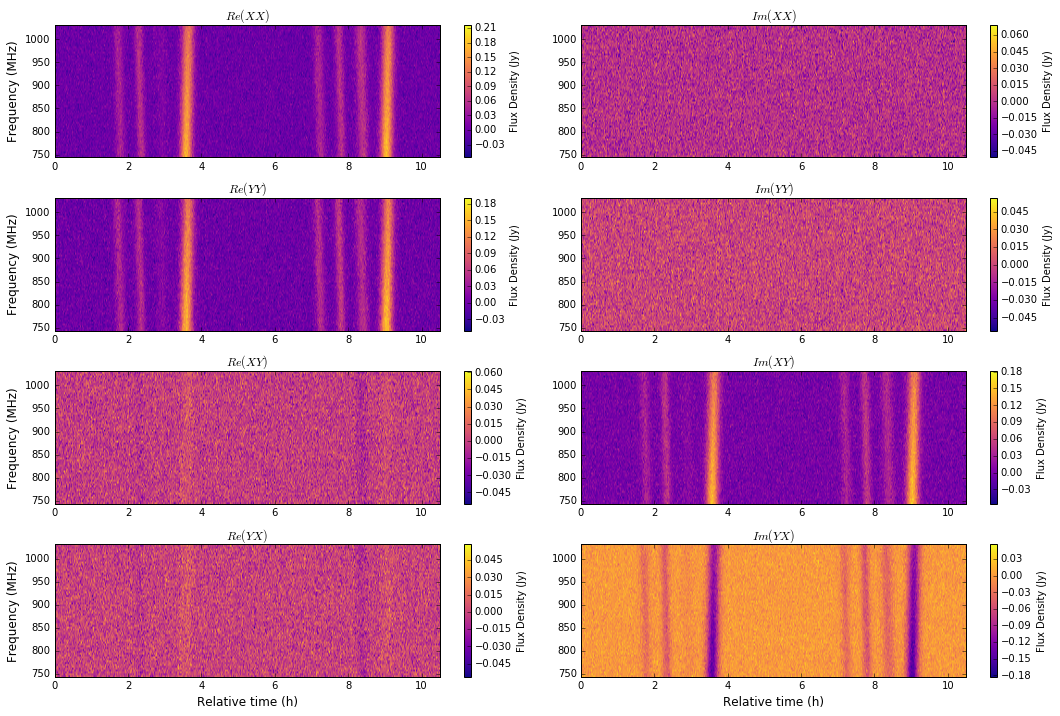

In [74]:
#a function to plot our dynamic spectra
def plot_ds(fig, ax, data, time = time, freq = freq):
    
    ds = ax.imshow(np.transpose(data),
                    aspect = 'auto', #make the aspect ratio sensible
                    origin = 'lower', #put the origin in the lower left corner
                    extent = [time[0], time[-1], freq[0], freq[-1]], #set the axis values
                    cmap = 'plasma' #use an attractive colormap. 
                  )
    #create a color-bar and set its label
    fig.colorbar(ds, ax = ax).set_label('Flux Density (Jy)', fontsize = 10)
    
    return ds

fig, axes = plt.subplots(4, #4 rows of axes
                               2, #2 columns of axes
                              figsize = (15, 10) # a nice big figure
                              )

#set up an array of labels for the axes
labels = np.array([ [r'$Re(XX)$', r'$Im(XX)$'], 
                    [r'$Re(YY)$', r'$Im(YY)$'], 
                    [r'$Re(XY)$', r'$Im(XY)$'], 
                    [r'$Re(YX)$', r'$Im(YX)$'] ]
                 )

for i, ipol in enumerate([XX, YY, XY, YX]):
    for j, part in enumerate([np.real(ipol), np.imag(ipol)]):
        ds = plot_ds(fig, axes[i, j], part, time = time, freq = freq)
        axes[i,j].set_title(labels[i,j], fontsize = 12) #set title
        

#set the axis labels where appropriate
for ax in axes[:, 0]:
    ax.set_ylabel('Frequency (MHz)', fontsize = 12)
for ax in axes[-1, :]:
    ax.set_xlabel('Relative time (h)', fontsize = 12)

fig.tight_layout()

Excellent! it looks like the noise hase gone down significantly, and we can now see emission in much more detail. We can check that the RMS noise decreased as expected by computing the standard deviation of a blank part of the dynamic spectra. You should check this for all four instrumental polarisations, but to save time for now we will just check the noise in the imaginary part of $XX$:

In [63]:
#RMS noise in one example baseline before averaging together:
rms_baseline = np.std(np.imag(XX_baseline[:, :, baseline]))
rms_avg = np.std(np.imag(XX))

print(rms_baseline)
print(rms_avg)

0.13936412325375994
0.012717246540105769


So the RMS has decreased from $\sim 140$ mJy to $\sim 13$ mJy.

__Exercise__:
By what factor has the RMS noise decreased? What factor decrease would you expect after averaging together 120 baselines, assuming the noise in each baseline is independent?

In [ ]:
#calculate the factor the RMS noise has decreased by here:



Write any written notes/answers for this exercise in the cell below

### Revision: measuring the Stokes parameters from instrumental polarisations

Recall that correlations of parallel and cross-hand voltage products (the "instrumental polarisations") give us a way to measure the true polarisation of emission from the sky in terms of the Stokes parameters.

For a standard linear-feed instrument, the instrumental polarisations are $XX$, $YY$, $XY$, and $YX$. These can be expressed in terms of the Stokes parameters as follows:<br>
$XX = I + Q$<br>
$YY = I - Q$<br>
$XY = U + jV$<br>
$YX = U - jV$,<br>
where $j$ is the imaginary unit, $\sqrt{-1}$.

These expressions can be rearranged to obtain the Stokes parameters in terms of the instrumental polarisations:<br>
$I = (XX + YY)/2$ — total (unpolarised) intensity;<br>
$Q = (XX - YY)/2$ — linear polarisation in vertical-horizontal basis;<br>
$U = (XY + YX)/2$ — linear polarisation in diagonal basis;<br>
$V = -j(XY - YX)/2$ — circular polarisation.<br>


__Exercise__:

Using the expressions above, construct dynamic spectra for each of the four Stokes parameters.<br> __Hint__: You can use the expression `1j` as the imaginary unit in your code.

In [ ]:
I = #complete this line
Q = #complete this line
U = #complete this line
V = #complete this line

Excellent! Now that we have got our dynamic spectra for each Stokes parameter, we can plot them below.

## Analysis of dynamic spectra

__Exercise__<br>
Using the `plot_ds` function from above, construct a figure showing dynamic spectra for the __real part__ (*hint*: use `np.real`) of the four Stokes parameters $I$, $Q$, $U$, $V$.

In [ ]:
fig, axes = plt.subplots(4, #4 rows of axes
                         1, #1 column of axes
                         figsize = (15, 10) # a nice big figure
                         )

labels = [r'$I$', r'$Q$', r'$U$', r'$V$']

for i, stokes in enumerate([I, Q, U, V]):
    #use the plot_ds function here
    ds = #complete this line
    
    #set the axis title
    axes[i].set_title(labels[i], fontsize = 12)
    
    
#set the axis labels here by completing the following lines:

#for ax in axes[:]:
    #ax. ??? #set y axis labels
#axes[???].set_xlabel(???) #set x axis label on the bottom

fig.tight_layout() #trim the figure and make it fit well

Excellent! So we can see that the bursts show up strongly in Stokes $V$, which means they are strongly circularly polarised, but some also show up quite weakly in Stokes $Q$ and $U$, which means there is a linearly-polarised component of the emission for some bursts. Emission that is both circularly __and__ linearly polarised is *elliptically* polarised. It is also interesting to note that the circularly polarised emission is always positive, which means that it is right-handed circular (following the IAU convention of circular polarisation).

We can also see that there are 8 bursts in total - 7 are very well-detected, and one is quite faint. The bursts appear to occur in sets of four. The first three appear to drift through the dynamic spectrum at a very similar drift rate, and the fourth drifts in an opposite direction.<br>
We can also see the pattern of bursts appears to *repeat* after ~5.5 hours, which is suspiciously close to the known rotation period of UV Ceti. Although the observation ends before we can sample another rotation, this repetition strongly suggests we are seeing *periodic* radio emission, like from a pulsar.

In summary:
- The bursts are circularly and elliptically polarised
- The bursts appear to repeat after about one stellar rotational period, strongly suggesting they are periodic pulses
- Three bursts from each set have very similar drift rates, and one appears to drift in the opposite direction. 

__Exercise__<br>
In the next exercise, we are going to compute the fractional polarisation of the emission:<br>
$\sqrt{Q^2 + U^2 + V^2}~/~I$

__Hints__: To do this, you might like to use the `np.sqrt` function. To compute something like $a^2$ in `python`, we can use the double-asterisk syntax: `a**2.0`.

In [ ]:
frac_pol = #complete this line

Now we can plot out our fractional polarisation dynamic spectrum. To do this, we'll first create a modified version of our dynamic spectrum plotting function to be a little more tuned to this type of plot:

In [112]:
#a function to plot our dynamic spectra
def plot_fracpol(fig, ax, data, time = time, freq = freq, low = 0.0, high = 1.0):
    
    ds = ax.imshow(np.transpose(data),
                    aspect = 'auto', #make the aspect ratio sensible
                    origin = 'lower', #put the origin in the lower left corner
                    extent = [time[0], time[-1], freq[0], freq[-1]], #set the axis values
                    cmap = 'viridis', #use an attractive colormap. 
                    clim = (low, high) #set color limits to something sensible
                  )
    #create a color-bar and set its label
    fig.colorbar(ds, ax = ax).set_label('Polarisation fraction', fontsize = 10)
    
    return ds

To make the fractional polarisation dynamic spectrum look nice, we should blank out regions where there is no emission, because the fractional polarisation is ill-defined there (fractional polarisation of noise doesn't make much sense). To do this, we will use numpy's masked-array functionality, and mask out anywhere in the fractional polarisation where the Stokes I intensity is less than 2.5 times the RMS noise.

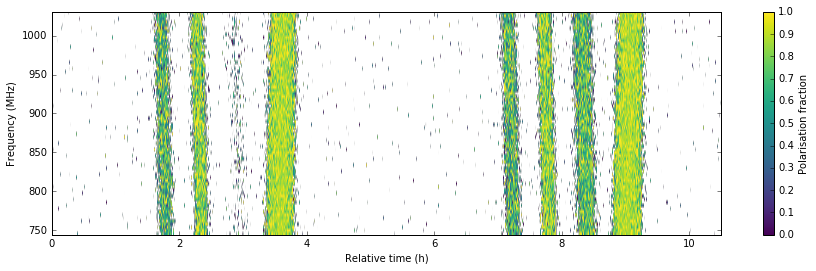

In [111]:
import numpy.ma as ma #masked array functionality

#estimate RMS noise from imaginary part of Stokes I spectrum:
rms_I = np.std(np.imag(I))

#mask the fractional polarisation array where the Stokes I intensity is less than 2.5*rms_I
frac_pol = ma.masked_where(np.real(I) < 2.5 * rms_I, frac_pol)

#now plot the fractional polarisation dynamic spectrum using our new function:
fig, ax = plt.subplots(1, 1, figsize = (15,4))
ds = plot_fracpol(fig, ax, np.real(frac_pol))

ax.set_xlabel('Relative time (h)')
ax.set_ylabel('Frequency (MHz)')
plt.show()

__Exercise__:<br>
Using `np.mean`, average the dynamic spectra over the *frequency* axis (axis 1) to create frequency-averaged light-curves.

In [ ]:
I_lc = #complete this line
Q_lc = #complete this line
U_lc = #complete this line
V_lc = #complete this line

fig, ax = plt.subplots(1, 1, figsize = (12,7))

ax.plot(time, np.real(I_lc), label = r'$I$')
ax.plot(time, np.real(V_lc), label = r'$V$')
ax.plot(time, np.real(Q_lc), label = r'$Q$')
ax.plot(time, np.real(U_lc), label = r'$U$')
ax.legend()

ax.set_xlim(time[0], time[-1])

ax.set_xlabel('Relative time (h)')
ax.set_ylabel('Flux Density (Jy)')

plt.show()

The light curves give us the best signal-to-noise ratio possible, although obviously we lose any spectral information of the bursts.

It should now be very clear that the bursts are periodic.<br>What are the best ways of measuring the periodicity? We could try the standard techniques such as Fourier transforms or periodograms. However, with only two rotational periods sampled in these observations, these techniques will not be very successful. Instead, we will use the *autocorrelation function*, which measures how similar a dataset is to a shifted (*lagged*) version of itself. Given that we have a set of four bursts that appear to repeat, the autocorrelation of our data should show a peak at period present in the data. We will do this below.

## Exercise solutions

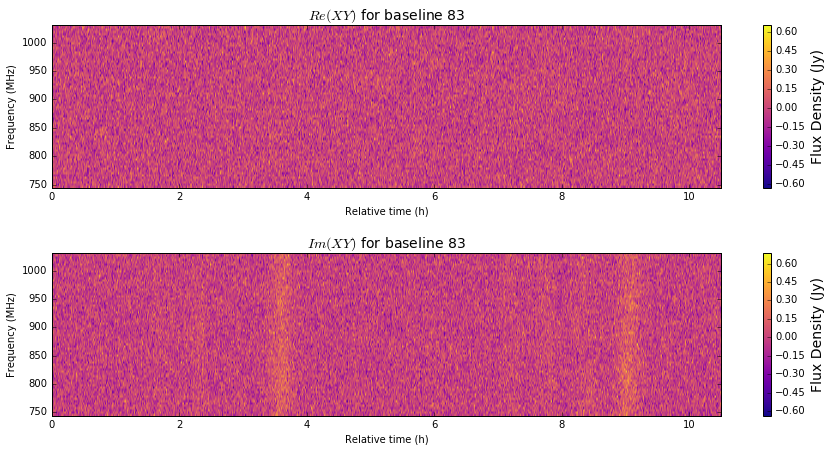

In [113]:
#first, initialise a figure with two subplots:
fig, (ax1, ax2) = plt.subplots(2, #two rows of axes
                               1, #one column of axes
                              figsize = (15, 7) # a nice big figure
                              )

#choose any baseline number:
baseline = 83

#get the XX dynamic spectrum for this baseline:
XY_test = XY_baseline[:, :, baseline] # The colon ":" selects all indices for that axis

#now we plot the real and imaginary parts using pyplot's imshow function
re = ax1.imshow(np.transpose(np.real(XY_test)),
          aspect = 'auto', #make the aspect ratio sensible
          origin = 'lower', #put the origin in the lower left corner
          extent = [time[0], time[-1], freq[0], freq[-1]], #set the axis values
          cmap = 'plasma' #Feel free to experiment with different colormaps e.g. viridis, magma, Blues
          )
#create a color-bar and set its label
fig.colorbar(re, ax = ax1).set_label('Flux Density (Jy)', fontsize = 14)


#set the axis labels
ax1.set_xlabel('Relative time (h)')
ax1.set_ylabel('Frequency (MHz)')
ax1.set_title(r'$Re(XY)$ for baseline {}'.format(baseline), fontsize = 14)

im = ax2.imshow(np.transpose(np.imag(XY_test)),
          aspect = 'auto', #make the aspect ratio sensible
          origin = 'lower', #put the origin in the lower left corner
          extent = [time[0], time[-1], freq[0], freq[-1]], #set the axis values
          cmap = 'plasma' #use an attractive colormap
          )
#create a color-bar and set its label
fig.colorbar(im, ax = ax2).set_label('Flux Density (Jy)', fontsize = 14)

#set the axis labels
ax2.set_xlabel('Relative time (h)')
ax2.set_ylabel('Frequency (MHz)')
ax2.set_title(r'$Im(XY)$ for baseline {}'.format(baseline), fontsize = 14)

fig.subplots_adjust(hspace = 0.4) #adjust subplots so that axis labels and titles don't overlap

In [42]:
XX = np.mean(XX_baseline, axis = 2) #axis = 2 specifies that we take the mean over the third axis
YY = np.mean(YY_baseline, axis = 2)
XY = np.mean(XY_baseline, axis = 2)
YX = np.mean(YX_baseline, axis = 2)

So the RMS noise has decreased by a factor of ~11. This makes sense, as we have averaged together 120 'independent' samples of noise, so we would expect the noise to decrease by a factor of $\sqrt{120} = 10.954$.

__Note__: This is absolutely a best-case scenario. In real-life examples, the reduction in RMS noise may be somewhat less than $\sqrt{N}$, where $N$ is the number of samples (e.g. time samples, frequency samples, etc.). This can be caused by a number of factors, including RFI, calibration errors, and the fact that the $N$ samples are not necessarily independent.

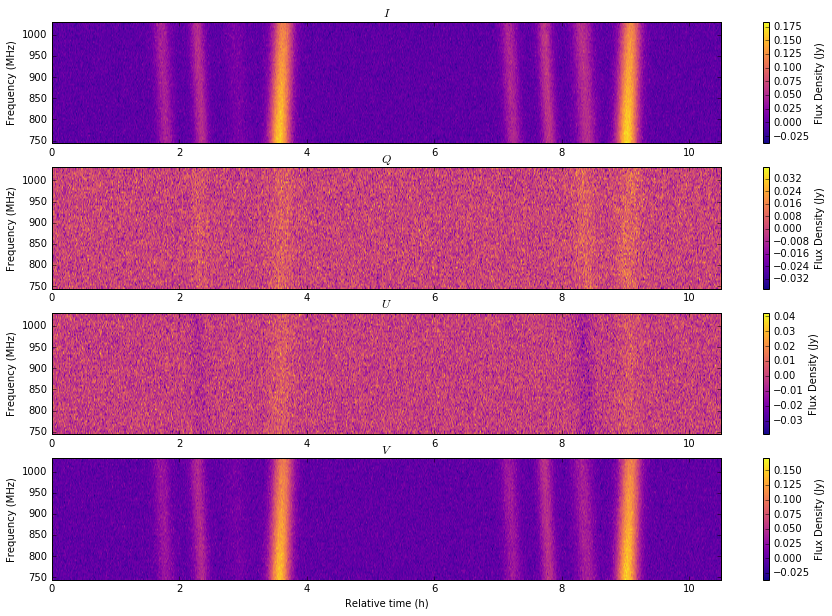

In [78]:
fig, axes = plt.subplots(4, #4 rows of axes
                         1, #1 column of axes
                         figsize = (15, 10) # a nice big figure
                         )

labels = [r'$I$', r'$Q$', r'$U$', r'$V$']

for i, stokes in enumerate([I, Q, U, V]):
    #use the plot_ds function here
    ax = axes[i]
    ds = plot_ds(fig, ax, np.real(stokes), time = time, freq = freq) #complete this line
    
    #set the axis title
    axes[i].set_title(labels[i], fontsize = 12)
    
    
#set the axis labels here by filling in :
for ax in axes[:]:
    ax.set_ylabel('Frequency (MHz)')

axes[-1].set_xlabel('Relative time (h)')

fig.tight_layout()

In [103]:
frac_pol = np.sqrt(Q**2.0 + U**2.0 + V**2.0)/I

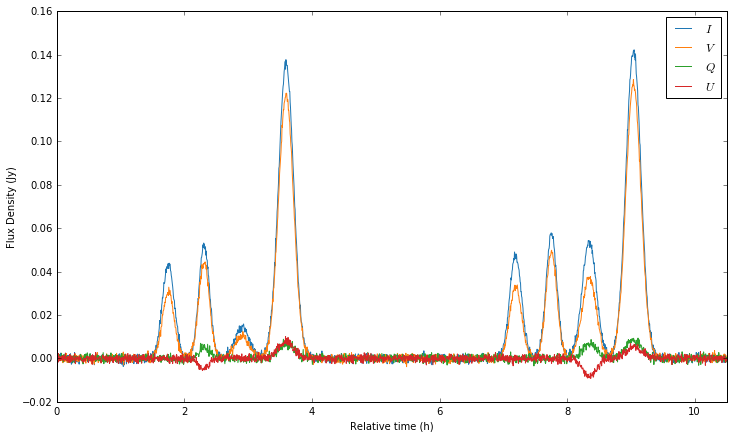

In [119]:
I_lc = np.mean(I, axis = 1)#complete this line
Q_lc = np.mean(Q, axis = 1)#complete this line
U_lc = np.mean(U, axis = 1)#complete this line
V_lc = np.mean(V, axis = 1)#complete this line

fig, ax = plt.subplots(1, 1, figsize = (12,7))

ax.plot(time, np.real(I_lc), label = r'$I$')
ax.plot(time, np.real(V_lc), label = r'$V$')
ax.plot(time, np.real(Q_lc), label = r'$Q$')
ax.plot(time, np.real(U_lc), label = r'$U$')
#ax.plot(time, np.real(V_lc), label = r'$V$')
ax.legend()

ax.set_xlim(time[0], time[-1])

ax.set_xlabel('Relative time (h)')
ax.set_ylabel('Flux Density (Jy)')

plt.show()